In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Splitting patient identifiers into lists
def load_data(results_file, tcga_file):
    results_df = pd.read_csv(results_file)
    results_df['patients1'] = results_df['patients1'].str.split('|')
    results_df['patients2'] = results_df['patients2'].str.split('|')
    
    tcga_df = pd.read_csv(tcga_file, sep='\t')
    return results_df, tcga_df

def calculate_jaccard(cluster, subtype_patients):
    
    # Jaccard index for a cluster against a subtype
    intersection = len(set(cluster) & set(subtype_patients))
    union = len(set(cluster) | set(subtype_patients))
    
    #Zero divison!
    return intersection / union if union else 0

def analyze_clusters(results_df, tcga_df):
    subtypes = tcga_df['PAM50'].unique()
    cluster_indices = {1: {}, 2: {}}

    for index, row in results_df.iterrows():

        for cluster_num, cluster_col in enumerate(['patients1', 'patients2'], start=1):
            cluster_patients = row[cluster_col]
            
            #Jaccard index for each subtype
            for subtype in subtypes:
                subtype_patients = tcga_df[tcga_df['PAM50'] == subtype]['sample_id']
                jaccard_index = calculate_jaccard(cluster_patients, subtype_patients)
                
                cluster_indices[cluster_num].setdefault(subtype, []).append(jaccard_index)

    return cluster_indices


results_df, tcga_df = load_data('/Users/yazgisert/Desktop/breast_trans/run1.csv', '/Users/yazgisert/Desktop/tez/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv')
cluster_analysis = analyze_clusters(results_df, tcga_df)
print(cluster_analysis)


{1: {'LumB': [0.3021978021978022], 'Her2': [0.08453837597330367], 'LumA': [0.38882921589688507], 'Normal': [0.028604118993135013], 'Basal': [0.1382636655948553]}, 2: {'LumB': [0.08829568788501027], 'Her2': [0.1111111111111111], 'LumA': [0.11149825783972125], 'Normal': [0.029535864978902954], 'Basal': [0.1935483870967742]}}


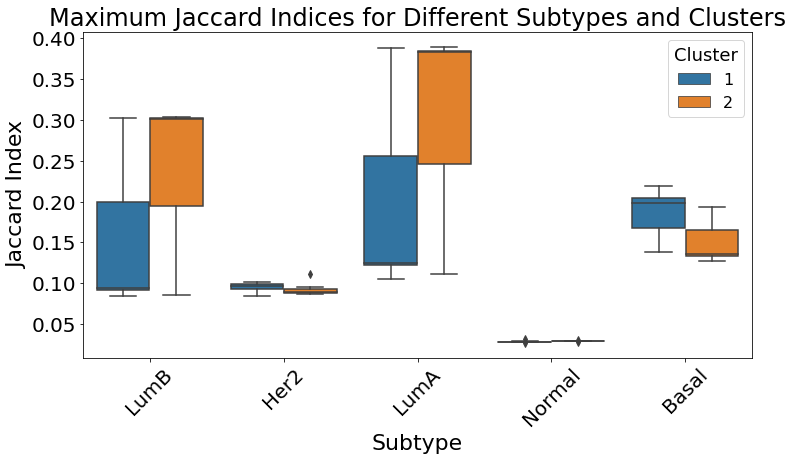

In [6]:
def aggregate_results(all_runs):
    aggregated_results = {1: {}, 2: {}}

    for run_results in all_runs:
        for cluster_num in [1, 2]:
            #subtype and indices pairs from the results of the current cluster
            for subtype, indices in run_results[cluster_num].items():
                if subtype not in aggregated_results[cluster_num]:
                    aggregated_results[cluster_num][subtype] = []

                #Maximum Jaccard index for each subtype
                aggregated_results[cluster_num][subtype].append(max(indices))

    return aggregated_results

def plot_results(aggregated_results):
    data_to_plot = []
    
    for cluster_num, subtypes in aggregated_results.items(): 
        for subtype, values in subtypes.items():
            for value in values:
                data_to_plot.append({'Cluster': cluster_num, 'Subtype': subtype, 'Jaccard Index': value})

    df_to_plot = pd.DataFrame(data_to_plot)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Subtype', y='Jaccard Index', hue='Cluster', data=df_to_plot)

    plt.xticks(rotation=45, fontsize=20)  
    plt.yticks(fontsize=20)  
    plt.xlabel('Subtype', fontsize=22) 
    plt.ylabel('Jaccard Index', fontsize=22) 
    plt.title('Maximum Jaccard Indices for Different Subtypes and Clusters', fontsize=24) 
    plt.legend(title='Cluster',  fontsize=16, title_fontsize=18) 
    
    plt.savefig('/Users/yazgisert/Desktop/breast_trans/plot.png')
    plt.show()


result_files = ['/Users/yazgisert/Desktop/breast_trans/run1.csv',
               '/Users/yazgisert/Desktop/breast_trans/run2.csv',
               '/Users/yazgisert/Desktop/breast_trans/run3.csv',
               '/Users/yazgisert/Desktop/breast_trans/run4.csv',
               '/Users/yazgisert/Desktop/breast_trans/run5.csv',
               '/Users/yazgisert/Desktop/breast_trans/run6.csv',
               '//Users/yazgisert/Desktop/breast_trans/run7.csv'] 
tcga_file = '/Users/yazgisert/Desktop/tez/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv'
all_runs = []

for file in result_files:
    results_df, tcga_df = load_data(file, tcga_file)
    cluster_analysis = analyze_clusters(results_df, tcga_df)
    all_runs.append(cluster_analysis)

aggregated_results = aggregate_results(all_runs)
plot_results(aggregated_results)